In [1]:
import pandas as pd
# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
train.head()

,id,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
0,0,3556.0,2489.0,265.19,77.53,176.55,0.00,4.20,307.91,52,0,7515.0,1
1,1,1906.0,134.0,1442.61,551.90,876.07,112.10,168.15,1735.48,20,1,1756.0,0
2,2,1586.0,71.0,1332.74,684.20,655.26,244.95,216.52,1820.04,28,1,1311.0,0
3,3,683.0,94.0,419.23,255.80,162.17,72.05,44.68,538.22,55,1,1443.0,0
4,4,1032.0,71.0,1102.72,480.27,625.30,188.78,130.77,1427.97,28,1,1542.0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        87 non-null     int64  
 1   MO HLADR+ MFI (cells/ul)  86 non-null     float64
 2   Neu CD64+MFI (cells/ul)   86 non-null     float64
 3   CD3+T (cells/ul)          87 non-null     float64
 4   CD8+T (cells/ul)          87 non-null     float64
 5   CD4+T (cells/ul)          87 non-null     float64
 6   NK (cells/ul)             87 non-null     float64
 7   CD19+ (cells/ul)          87 non-null     float64
 8   CD45+ (cells/ul)          87 non-null     float64
 9   Age                       87 non-null     int64  
 10  Sex 0M1F                  87 non-null     int64  
 11  Mono CD64+MFI (cells/ul)  86 non-null     float64
 12  label                     87 non-null     int64  
dtypes: float64(9), int64(4)
memory usage: 9.0 KB


### Missing Data

In [4]:
missing_values = train.isnull().sum()
print(missing_values)

id                          0
MO HLADR+ MFI (cells/ul)    1
Neu CD64+MFI (cells/ul)     1
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    1
label                       0
dtype: int64


While checking for missing values, it seems that MO HLADR+ MFI (cells/ul), Neu CD64+MFI (cells/ul) and Mono CD64+MFI (cells/ul) have 3 missing values. In this case, I decided to fill in each missing data with its respective averaged values to overcome this issue without much loss of information provided by other features.

In [5]:
for col in ["MO HLADR+ MFI (cells/ul)", "Neu CD64+MFI (cells/ul)", "Mono CD64+MFI (cells/ul)"]:
    train[col] = train[col].fillna(train[col].mean())

### Imbalanced labels

<AxesSubplot:xlabel='label', ylabel='MO HLADR+ MFI (cells/ul)'>

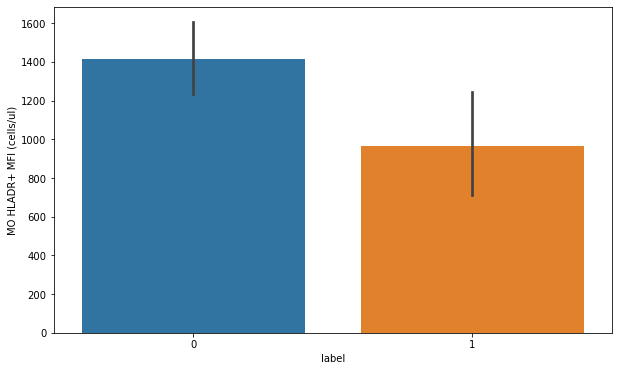

In [6]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'label', y = 'MO HLADR+ MFI (cells/ul)', data = train)

<AxesSubplot:xlabel='label', ylabel='Neu CD64+MFI (cells/ul)'>

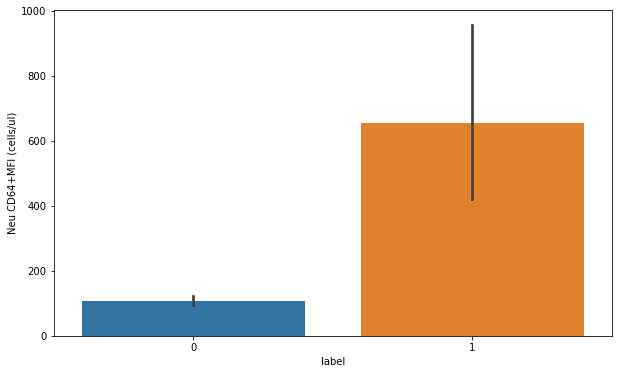

In [7]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'label', y = 'Neu CD64+MFI (cells/ul)', data = train)

<AxesSubplot:xlabel='label', ylabel='Mono CD64+MFI (cells/ul)'>

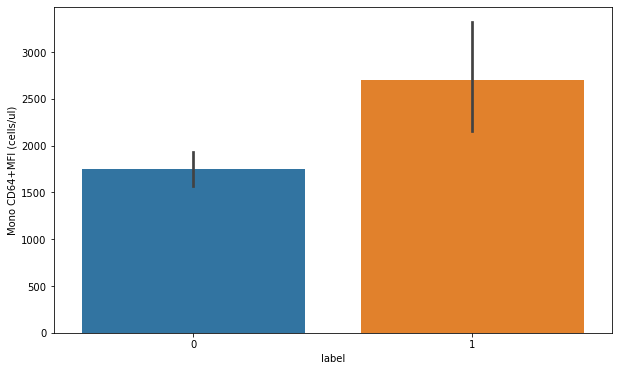

In [8]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'label', y = 'Mono CD64+MFI (cells/ul)', data = train)

By comparing the important features with the labels given in the train dataset, it can be observed that the train dataset has imbalanced labels. Hence, I decided to use SMOTE to help resample the dataset and balance out the labels used for model prediction later.

In [9]:
sm = SMOTE(random_state = 666)
train,y = sm.fit_resample(train[[i for i in train.columns if i not in['id','label']]], train['label'])
train['label'] = y
print(train.shape,train['label'].sum())

(116, 12) 58


### Log Transformation of Input Features

With the skewed dataset as observed from the imbalanced labels, log transformation is applied to the rest of the features supplemented to the model for prediction analysis later on. The binary dataset of `Sex0M1F` and `label` are excluded from this log transformation process and it makes sense not to alter the given age information under `Age` as well.

In [10]:
numerical_data = list(set(train.columns) - set(['Sex 0M1F', 'label']))
features_column = list(set(numerical_data) - set(['Age']))

In [11]:
print(features_column)

['NK (cells/ul)', 'CD19+ (cells/ul)', 'CD45+ (cells/ul)', 'CD3+T (cells/ul)', 'CD4+T (cells/ul)', 'CD8+T (cells/ul)', 'MO HLADR+ MFI (cells/ul)', 'Neu CD64+MFI (cells/ul)', 'Mono CD64+MFI (cells/ul)']


In [12]:
def log_transform(data, selected_features):
    for features in selected_features:
        data[features] = np.where(data[features]!=0, np.log10(data[features]), 0)
    return data

train = log_transform(train, features_column)
test = log_transform(test, features_column)

### Data Manipulation for Age and Sex Features

The `Age` feature is categorized for easier model training and prediction as we're now increasing the occurences of such incident in an equal interval of ages. Moreover, the binary `Sex0M1F` feature is transformed from a categorical variable into indicator variables. And so, after extracting indicator information from `Sex0M1F`, the column is dropped.

In [13]:
def transform_age(age):
    return age // 5

train['Age'] = train['Age'].apply(transform_age)
test['Age'] = test['Age'].apply(transform_age)

train['Sex 0M1F'] = train['Sex 0M1F'].astype(str)
test['Sex 0M1F'] = test['Sex 0M1F'].astype(str)

train[['IsMale','IsFemale']] = pd.get_dummies(train['Sex 0M1F'])
test[['IsMale','IsFemale']] = pd.get_dummies(test['Sex 0M1F'])

train = train.drop('Sex 0M1F',axis=1)
test = test.drop('Sex 0M1F',axis=1)

## Data Transformation with MinMaxScaler()

Without distorting the dataset much, MinMaxScaler() is applied to transform all the given features and standardize them into a range of values from 0 to 1. This allows the data points to be generalized with lower distances between each data point to further rule out the possibly of skewed data.

In [14]:
scaler = MinMaxScaler()
columns = ['MO HLADR+ MFI (cells/ul)', 'Neu CD64+MFI (cells/ul)',
       'CD3+T (cells/ul)', 'CD8+T (cells/ul)', 'CD4+T (cells/ul)',
       'NK (cells/ul)', 'CD19+ (cells/ul)', 'CD45+ (cells/ul)', 'Mono CD64+MFI (cells/ul)']

scaler.fit(train[columns])

train[columns] = scaler.transform(train[columns])
test[columns] = scaler.transform(test[columns])

## Train-Test Split

In [15]:
X_train,y_train = train[[i for i in train.columns if i not in['id','label']]],train['label']
                        
X_test = test[[i for i in train.columns if i not in['id','label']]]

## Prediction Modelling - Random Forest Classifier

The random forest classifier model is chosen as it will be able to handle any missing values moving forward and it can also maintain the accuracy while working with a large proportion of data.

In [16]:
# Random Forest
parameters = {'criterion':('gini','entropy'), 'min_samples_split':[2,5,10],
             'min_samples_leaf':[1,2,5],'max_features':["auto", "sqrt", "log2"],
             'oob_score':[True,False],'class_weight':["balanced","balanced_subsample"]}

rf = RandomForestClassifier(200,random_state = 39)

clf = GridSearchCV(rf, parameters,cv = 10)

clf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=39),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ('gini', 'entropy'),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'oob_score': [True, False]})

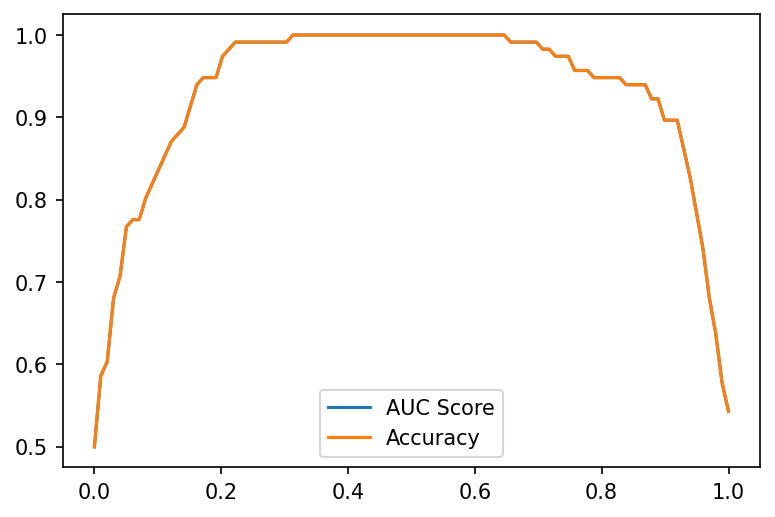

In [17]:
scores = []
accuracies = []

for threshold in np.linspace(0,1,100):
    probability_of_prediction = clf.predict_proba(X_train)

    y_pred = (probability_of_prediction [:,1] >= threshold).astype('int')
    
    scores.append(roc_auc_score(y_train, y_pred))
    accuracies.append(accuracy_score(y_train, y_pred))
    
plt.figure(figsize = [6,4],dpi = 150)
plt.plot(np.linspace(0,1,100),scores, label = 'AUC Score')
plt.plot(np.linspace(0,1,100),accuracies,label='Accuracy')
plt.legend()

In [18]:
threshold = 0.5

probability_of_prediction = clf.predict_proba(X_train)

y_pred = (probability_of_prediction [:,1] >= threshold).astype('int')

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        58

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116



In [19]:
probability_of_prediction = clf.predict_proba(X_test)

prediction = (probability_of_prediction [:,1] >= threshold).astype('int')

pd.DataFrame({"id":range(59),"label":prediction}).to_csv("submission.csv",index=None)

Since the random forest classification model performed well, it's time for submissions! I did observe that regardless of what model I employed moving forward, the random forest classification model performed better. However, the Kaggle leaderboard score of 96.55% is pretty close to being fully accurate and so I tried to submit several attempts by correcting my predictions to obtain a score of 100%.